# Traditional Machine Learning models for predicting future trade Volume.

In this notebook, we will usually use normalized features and volume. The volume will be denormalized only for the purpose of model evaluation. We will use StandardScaler for normalization.

We can draw conclusion from the Exploratory Data Analysis that not all features from the original dataset are usefull for prediction and few more additional features can be added. Models in this notebook will work with usually with following columns:

| Feature  | Type | Description |
| ------------- | ------------- ||
| Volume X  | float64  |Historial trading volume shifted by X|
| AdjCloseDiff X  | float64  |Historical difference between AdjClose price of two consecutive days shifted by X|
| HighLowDiff X  | float64  |Historical difference between High and Low price shifted by X|
| DayOfWeek X  | one-hot |One-hot encoding value for each day|
| Month X  | one-hot  |One-hot encoding value for each month|

Le'ts now read the normalized data.

In [1]:
import sys
import datetime
sys.path.append("../") # go to parent dir
from util.read_data import DataReader
from util.evaluator import ModelEvaluator
from util.visualizer import visialize_errors
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
reader = DataReader()
df = reader.read_all_data_normalized()
evaluator = ModelEvaluator(reader.label_scaler)

df_test_features, series_test_volume = reader.get_test_data(df)

Baseline model is very simple, predicting the same value of Volume as yesterday: $\hat{E}[v_{d+1}]=v_d$

In [3]:
def baseline_model(volume):
    pred_volume = volume.shift(1)
    return pred_volume

In [4]:
baseline_pred_volume = baseline_model(series_test_volume)
# the first value is nan, we will ignore them by mapping [1:]
baseline_model_results = evaluator.evaluate("baseline", series_test_volume[1:], baseline_pred_volume[1:])
print(baseline_model_results)

baseline: MSE = 3.684400e+17, R2 = 0.033, conf. int. 95% of error = (-53,069,427 - 53,341,067)


The baseline r2 score is **0.033**, which is slightly better than predicting average value.

Another simple model would use moving average over some time window.
The model is following: $V_{d+1}=\frac 1n \sum_{i=0}^{n-1} V_{d-i}$.
We can try multiple n values, le'ts try following values: {1, 3, 5, 10, 50, 100}

In [5]:
def moving_average_model(volume, n):
    pred_volume = volume.rolling(n).mean().shift(1)
    return pred_volume

In [6]:
window_size = [1,2,3,4,5,8,10,15,20,50]
# first few initial values will have nan values, we will ignorem them by mapping [n:]
moving_average_result_list = [evaluator.evaluate("moving_average {}".format(n), 
    series_test_volume[n:],
    moving_average_model(series_test_volume, n)[n:]) 
    for n in window_size]

for result in moving_average_result_list:
    print(result)


moving_average 1: MSE = 3.684400e+17, R2 = 0.033, conf. int. 95% of error = (-53,069,427 - 53,341,067)
moving_average 2: MSE = 3.136891e+17, R2 = 0.178, conf. int. 95% of error = (-49,344,246 - 48,940,358)
moving_average 3: MSE = 3.099159e+17, R2 = 0.189, conf. int. 95% of error = (-49,530,282 - 48,259,465)
moving_average 4: MSE = 3.130410e+17, R2 = 0.182, conf. int. 95% of error = (-50,315,382 - 48,064,990)
moving_average 5: MSE = 3.128615e+17, R2 = 0.184, conf. int. 95% of error = (-52,614,748 - 45,836,522)
moving_average 8: MSE = 3.332384e+17, R2 = 0.136, conf. int. 95% of error = (-59,016,798 - 42,898,679)
moving_average 10: MSE = 3.298599e+17, R2 = 0.147, conf. int. 95% of error = (-62,279,075 - 39,324,762)
moving_average 15: MSE = 3.368760e+17, R2 = 0.136, conf. int. 95% of error = (-68,739,344 - 34,466,184)
moving_average 20: MSE = 3.577937e+17, R2 = 0.089, conf. int. 95% of error = (-73,827,894 - 33,084,952)
moving_average 50: MSE = 3.892483e+17, R2 = 0.057, conf. int. 95% of e

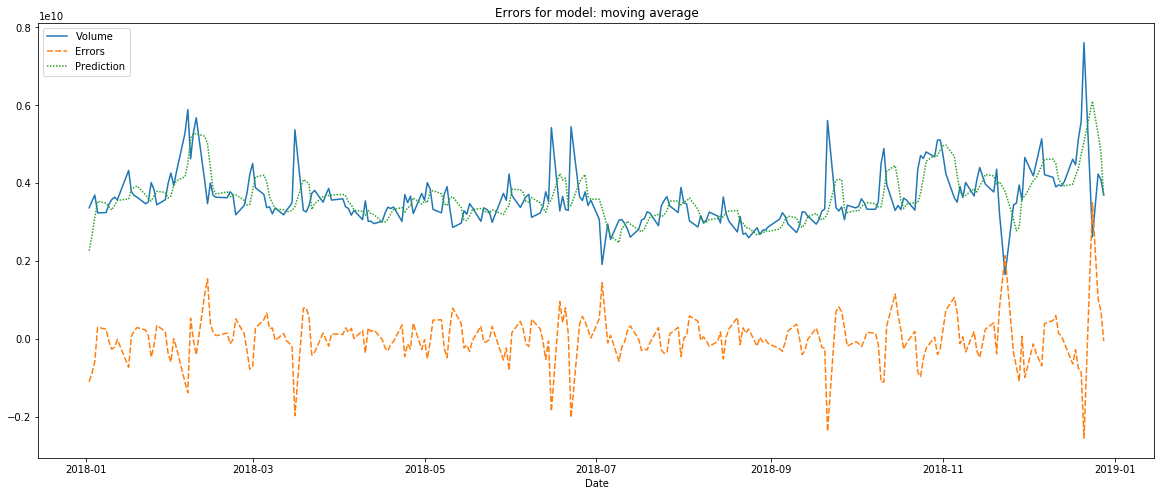

In [7]:
visialize_errors("moving average", moving_average_result_list[2].volume_true, moving_average_result_list[2].errors)

The moving average models improve the baseline , with the best R2 score = **0.189** for window size = 3. The window size 1 also confirms that the algorithm has correct implementation, as it has the same results as the baseline model.
 
Graph of the prediction for sample time period shows expected results, that the peaks are smoothened and delayed.

Le'ts try to use exponential moving average.

In [8]:
def exp_moving_average_model(volume, n):
    pred_volume = volume.ewm(span=n).mean().shift(1)
    return pred_volume

In [9]:
window_size = [1,2,3,4,5,8,10,15,20,50]
exp_moving_average_result_list = [evaluator.evaluate("exp. moving_average {}".format(n), 
        series_test_volume[n:],
        exp_moving_average_model(series_test_volume, n)[n:])
                                                 for n in window_size]

for result in exp_moving_average_result_list:
    print(result)


exp. moving_average 1: MSE = 3.684400e+17, R2 = 0.033, conf. int. 95% of error = (-53,069,427 - 53,341,067)
exp. moving_average 2: MSE = 3.024401e+17, R2 = 0.207, conf. int. 95% of error = (-48,491,694 - 48,014,561)
exp. moving_average 3: MSE = 2.880625e+17, R2 = 0.246, conf. int. 95% of error = (-48,026,359 - 46,252,592)
exp. moving_average 4: MSE = 2.844844e+17, R2 = 0.257, conf. int. 95% of error = (-49,530,117 - 44,255,685)
exp. moving_average 5: MSE = 2.845396e+17, R2 = 0.258, conf. int. 95% of error = (-51,352,553 - 42,536,855)
exp. moving_average 8: MSE = 2.907816e+17, R2 = 0.246, conf. int. 95% of error = (-54,959,423 - 40,242,576)
exp. moving_average 10: MSE = 2.953661e+17, R2 = 0.237, conf. int. 95% of error = (-58,118,071 - 38,026,698)
exp. moving_average 15: MSE = 3.063394e+17, R2 = 0.215, conf. int. 95% of error = (-64,181,541 - 34,235,284)
exp. moving_average 20: MSE = 3.151585e+17, R2 = 0.198, conf. int. 95% of error = (-67,282,532 - 33,058,379)
exp. moving_average 50: M

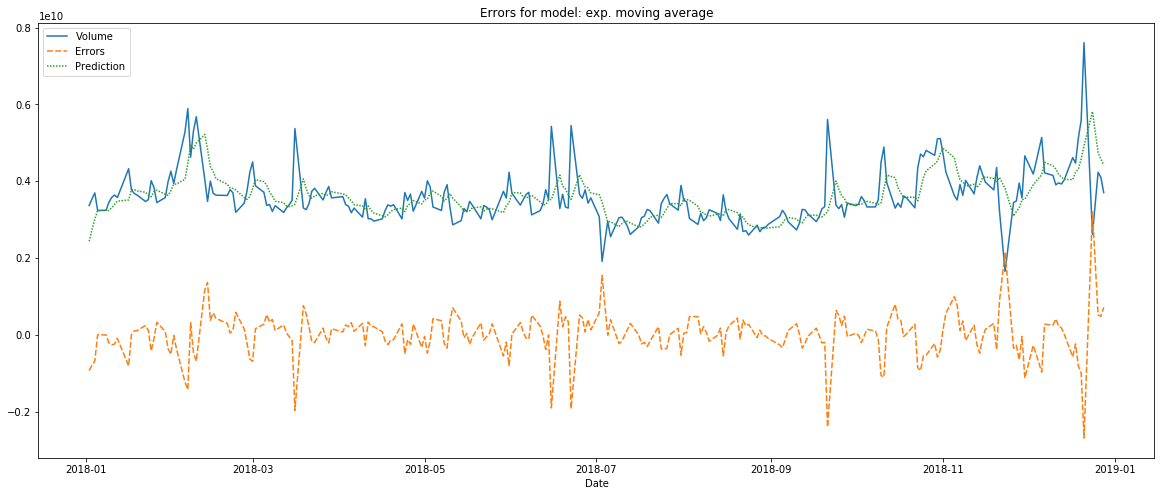

In [10]:
visialize_errors("exp. moving average", exp_moving_average_result_list[4].volume_true, exp_moving_average_result_list[4].errors)

Exponential moving average again improves the score, with the best R2 score = **0.258** for window size = 5.

The graph of the prediction and erros for the sample time period shows that the peaks copy the true values slightly better, as there is more weight on recent history.

Let's now try to learn linear regression, on the normalized historical features described in the table on the top of the notebook. The time window size will be variable. 

In [56]:
from sklearn.linear_model import LinearRegression

def linear_regression_model(features, volume):
    regressor = LinearRegression()
    
    regressor.fit(features, volume)
    return regressor

def eval_model(name, model_function, n, custom_callback=None, train_date_from = None):
    # prepare the features, first rows with nan values will not be included
    df_enriched = reader.prepare_window_features_for_training(df, n)[n:]
    if (train_date_from != None):
        df_enriched = df_enriched.loc[train_date_from:]

    train_features, train_volume = reader.get_train_data(df_enriched)
    test_features, test_volume = reader.get_test_data(df_enriched)

    regressor = model_function(train_features, train_volume)
    
    # allows to custom-enrich the results output
    if (custom_callback):
        random_forest_callback(train_features, regressor)
    
    print(evaluator.evaluate("{} {} on train".format(name, n), 
                             train_volume, regressor.predict(train_features)))
    result = evaluator.evaluate("{} {} on test ".format(name, n), 
                                test_volume, regressor.predict(test_features))
    print(result)
    return result


In [57]:
window_size = [1,2,3,4,5,8,10,15,20,50]
lin_regression_result_list = [eval_model("lin. reg.", 
                                             linear_regression_model, n) for n in window_size]

lin. reg. 1 on train: MSE = 3.346656e+17, R2 = 0.864, conf. int. 95% of error = (-17,339,747 - 17,339,747)
lin. reg. 1 on test : MSE = 3.178947e+17, R2 = 0.164, conf. int. 95% of error = (-102,699,885 - -3,956,311)

lin. reg. 2 on train: MSE = 2.970075e+17, R2 = 0.879, conf. int. 95% of error = (-16,336,977 - 16,336,977)
lin. reg. 2 on test : MSE = 2.728471e+17, R2 = 0.282, conf. int. 95% of error = (-87,058,696 - 4,421,449)

lin. reg. 3 on train: MSE = 2.906242e+17, R2 = 0.881, conf. int. 95% of error = (-16,162,359 - 16,162,359)
lin. reg. 3 on test : MSE = 2.635186e+17, R2 = 0.307, conf. int. 95% of error = (-83,280,301 - 6,622,419)

lin. reg. 4 on train: MSE = 2.864351e+17, R2 = 0.883, conf. int. 95% of error = (-16,116,850 - 15,977,809)
lin. reg. 4 on test : MSE = 2.603652e+17, R2 = 0.315, conf. int. 95% of error = (-82,637,816 - 6,725,368)

lin. reg. 5 on train: MSE = 2.809084e+17, R2 = 0.885, conf. int. 95% of error = (-15,933,504 - 15,853,735)
lin. reg. 5 on test : MSE = 2.54523

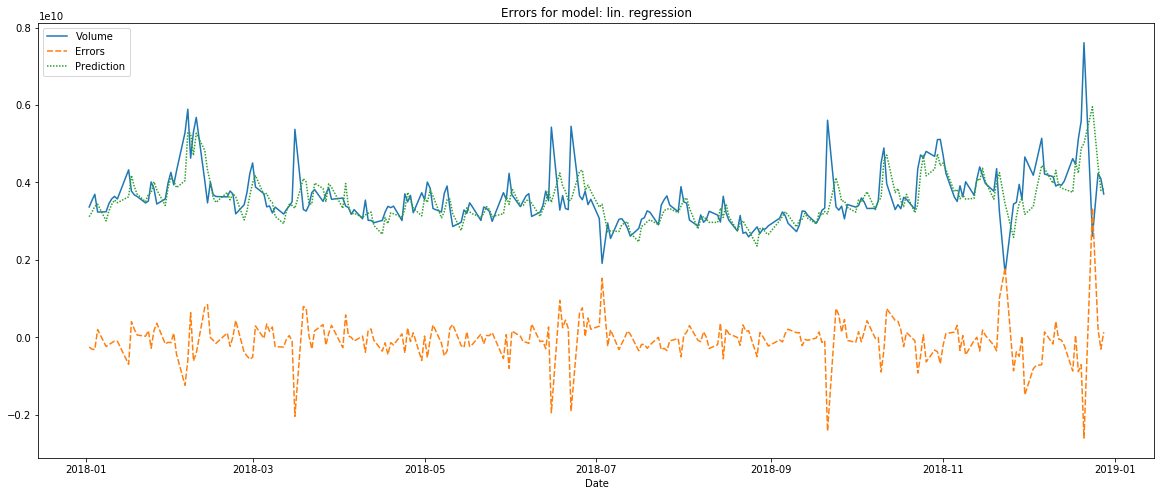

In [25]:
visialize_errors("lin. regression", lin_regression_result_list[6].volume_true, lin_regression_result_list[6].errors)

Linera regression has better results than exponential moving average, the best result is with R2 score = *0.340* for window size = 10.

The prediction and erros graph shows that the prediction are not moved in time contrary to moving and exponential moving averages. Still, model is not able to predict extreme peaks.

Let's not try to use another, random forest regressor, with the same features.

In [58]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_model(features, volume):
    regressor = RandomForestRegressor(n_estimators=100)
    
    regressor.fit(features, volume)
    return regressor

def random_forest_callback(train_features, regressor):
    importances = list(zip(train_features.columns, regressor.feature_importances_))
    importances.sort(key=lambda x: x[1], reverse = True)
    print("First 5 Feature importances:".format(n))
    for importance in importances[:5]:
        print('Feature: {:30} \t Importance: {}'.format(importance[0], importance[1]))


In [59]:
window_size = [1,3,5,10,20]
rand_forst_list = [eval_model("random forest", 
                                             random_forest_model, n, random_forest_callback) for n in window_size]

First 5 Feature importances:
Feature: Volume1                        	 Importance: 0.89408948961341
Feature: HighLowDiff1                   	 Importance: 0.030911804167861368
Feature: AdjCloseDiff1                  	 Importance: 0.02830344392298404
Feature: DayOfWeek_Monday               	 Importance: 0.009216762725095447
Feature: Month_12                       	 Importance: 0.004088891197588717
random forest 1 on train: MSE = 4.858182e+16, R2 = 0.980, conf. int. 95% of error = (-2,862,588 - 10,350,493)
random forest 1 on test : MSE = 3.109514e+17, R2 = 0.182, conf. int. 95% of error = (17,205,287 - 114,864,551)

First 5 Feature importances:
Feature: Volume1                        	 Importance: 0.8300224907435125
Feature: Volume2                        	 Importance: 0.0606884133606404
Feature: Volume3                        	 Importance: 0.026898437836942173
Feature: AdjCloseDiff1                  	 Importance: 0.013096635055537582
Feature: HighLowDiff1                   	 Importance: 

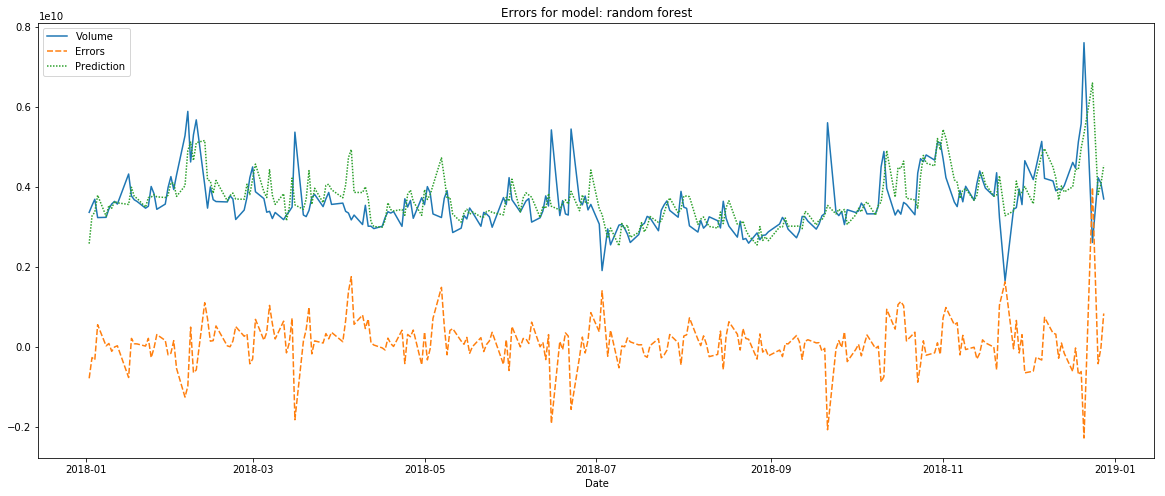

In [60]:
visialize_errors("random forest", rand_forst_list[2].volume_true, rand_forst_list[2].errors)

The difference between performance of the tran set and on the test set shows that model overfits on the train set. In comparison to previous models, model can sometimes have strange results, which look unexpected from the data - e.g. peak in the prediction starting at 2018-04, or failing to predict some peaks even with delay. The best R2 score is around **0.304** (changes with each run), for window size = 20.  



**Insights:**
* Model easily overfits to the train set
* The sorted list of feature importances shows that the most important feature for decission is Volume(t-1), followed by Volume(t-2).  
* The AdjCloseDiff1(t-1) and HighLowDiff1(t-1) does not seem important at all, compared Volumes in short history.


is Le't see SVM model, for comparison.

In [62]:
from sklearn.svm import SVR

def svm_model(features, volume):
    regressor = SVR(gamma='auto')
    
    regressor.fit(features, volume)
    return regressor0.304

In [76]:
window_size = [1,3,5,10,20]
svm_list = [eval_model("svm", svm_model, n) for n in window_size]

svm 1 on train: MSE = 2.952591e+17, R2 = 0.880, conf. int. 95% of error = (-55,589,224 - -23,015,390)
svm 1 on test : MSE = 3.036388e+17, R2 = 0.201, conf. int. 95% of error = (-88,611,036 - 7,893,085)

svm 3 on train: MSE = 2.413306e+17, R2 = 0.902, conf. int. 95% of error = (-45,180,461 - -15,724,379)
svm 3 on test : MSE = 2.640269e+17, R2 = 0.306, conf. int. 95% of error = (-82,695,807 - 7,293,575)

svm 5 on train: MSE = 2.226577e+17, R2 = 0.909, conf. int. 95% of error = (-39,852,495 - -11,552,309)
svm 5 on test : MSE = 2.735825e+17, R2 = 0.280, conf. int. 95% of error = (-58,054,761 - 33,548,592)

svm 10 on train: MSE = 2.003799e+17, R2 = 0.918, conf. int. 95% of error = (-39,563,225 - -12,700,390)
svm 10 on test : MSE = 2.803728e+17, R2 = 0.263, conf. int. 95% of error = (-33,649,922 - 59,083,253)

svm 20 on train: MSE = 1.753106e+17, R2 = 0.928, conf. int. 95% of error = (-33,098,718 - -7,942,905)
svm 20 on test : MSE = 2.985330e+17, R2 = 0.215, conf. int. 95% of error = (-2,402

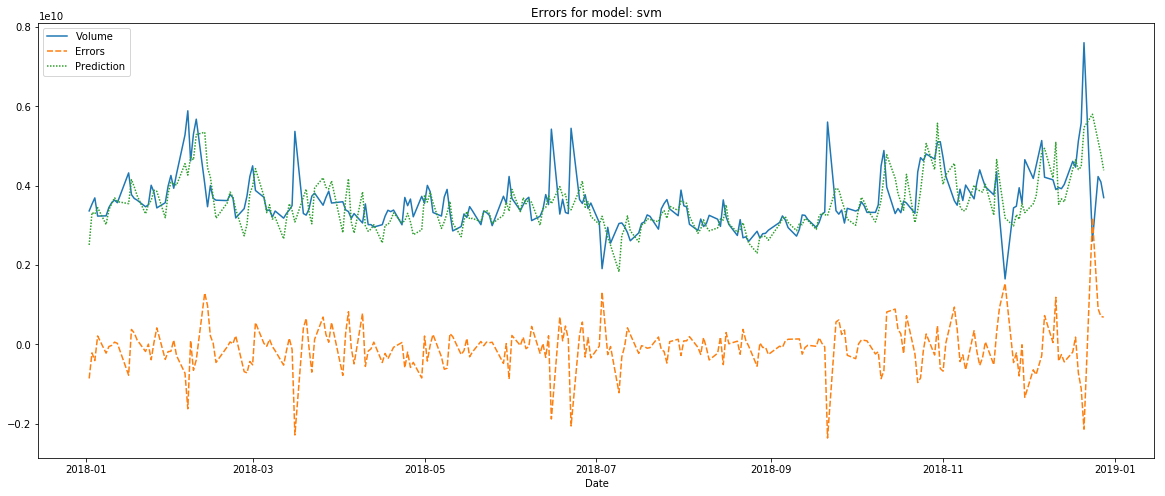

In [70]:
visialize_errors("svm", svm_list[1].volume_true, svm_list[1].errors)

The best SVM model is again overfitted to the train set. The best R2 score is **0.306** (changing with each run), which is similar to random forest results.

Model is also not very good at prediction peaks.

Let's try one last traditional ML model,  ridge regression with cross validation.

In [68]:
from sklearn import linear_model

def linear_ridge_model(features, volume):
    regressor = linear_model.RidgeCV(alphas=[0.1, 0.5, 1.0, 5, 10.0], cv=10)
    
    regressor.fit(features, volume)
    return regressor

In [71]:
window_size = [1,3,5,10,20]
ridge_result_list = [eval_model("ridge", linear_ridge_model, n) for n in window_size]

ridge 1 on train: MSE = 3.346656e+17, R2 = 0.864, conf. int. 95% of error = (-17,339,747 - 17,339,747)
ridge 1 on test : MSE = 3.178889e+17, R2 = 0.164, conf. int. 95% of error = (-102,705,255 - -3,962,585)

ridge 3 on train: MSE = 2.906244e+17, R2 = 0.881, conf. int. 95% of error = (-16,162,363 - 16,162,363)
ridge 3 on test : MSE = 2.634904e+17, R2 = 0.307, conf. int. 95% of error = (-83,290,612 - 6,607,291)

ridge 5 on train: MSE = 2.809307e+17, R2 = 0.885, conf. int. 95% of error = (-15,894,251 - 15,894,251)
ridge 5 on test : MSE = 2.542341e+17, R2 = 0.331, conf. int. 95% of error = (-80,735,678 - 7,569,085)

ridge 10 on train: MSE = 2.721949e+17, R2 = 0.889, conf. int. 95% of error = (-15,654,338 - 15,654,338)
ridge 10 on test : MSE = 2.509386e+17, R2 = 0.340, conf. int. 95% of error = (-76,367,315 - 11,363,247)

ridge 20 on train: MSE = 2.633851e+17, R2 = 0.892, conf. int. 95% of error = (-15,416,999 - 15,416,999)
ridge 20 on test : MSE = 2.618138e+17, R2 = 0.311, conf. int. 95% o

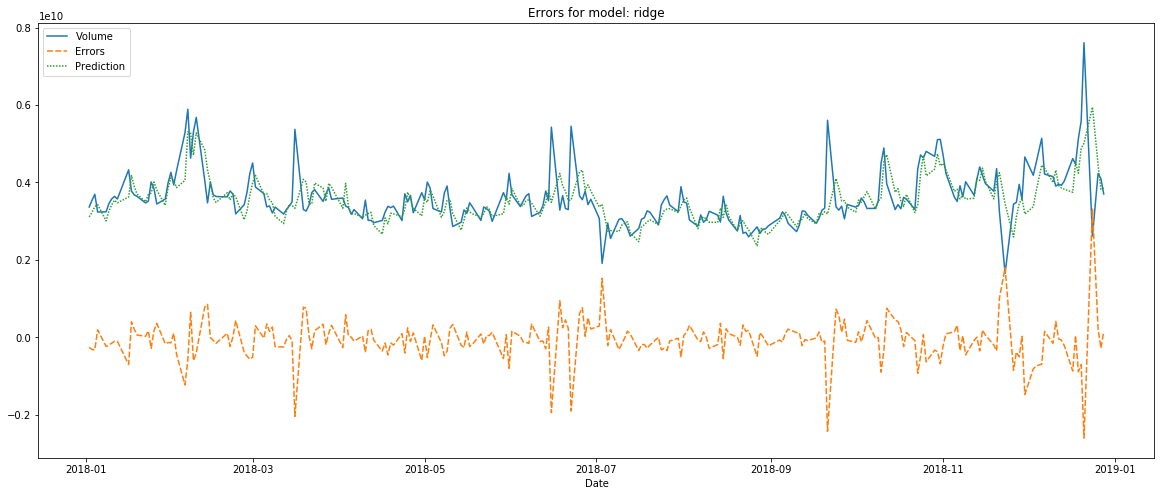

In [72]:
visialize_errors("ridge", ridge_result_list[3].volume_true, ridge_result_list[3].errors)

The best R2 score with RidgeCV model on the test set is similar to previous models, R2 score = **0.340** for window size = 5.

The next possible step with current data we have could be using exponential average with various spans as the features for more comples models, or assembly of various models.

**Hypothesis** More rewarding would probably be using more informative features. One of the possible such features could be number of expected earning announcements, ideally weighted by the market value of the company.

**Hypothesis** No model with the features used does not have very good performance. The hypothesis is that **historical Market data on its own are not very good features to predict next trade Volume. The market reaches equilibrium at the end of each date and all available information was already processed.**
